In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
ls /kaggle/input/gtsrb-german-traffic-sign

meta/  Meta/  Meta.csv  test/  Test/  Test.csv  train/  Train/  Train.csv


In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
print(df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Base directory and CSV
base_dir = "/kaggle/input/gtsrb-german-traffic-sign/"
df = pd.read_csv(os.path.join(base_dir, "Train.csv"))

# ✅ Reduce to 5000 images (random selection)
df_subset = df.sample(n=12000, random_state=42).reset_index(drop=True)

# Lists for storing processed data
images_rgb = []
images_gray = []
labels = []

# Preprocessing loop
for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    img_path = os.path.join(base_dir, row['Path'])  # Full image path
    img = cv2.imread(img_path)

    if img is not None:
        img_rgb = cv2.resize(img, (32, 32))
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

        images_rgb.append(img_rgb)
        images_gray.append(img_gray)
        labels.append(row['ClassId'])
    else:
        print("❌ Failed to load:", img_path)

# Convert to NumPy arrays
images_rgb = np.array(images_rgb)
images_gray = np.array(images_gray)
labels = np.array(labels)

# Info
print("✅ Loaded:", len(images_rgb), "images")
print("RGB shape:", images_rgb.shape)
print("Gray shape:", images_gray.shape)
print("Labels shape:", labels.shape)


100%|██████████| 12000/12000 [00:39<00:00, 306.01it/s]

✅ Loaded: 12000 images
RGB shape: (12000, 32, 32, 3)
Gray shape: (12000, 32, 32)
Labels shape: (12000,)


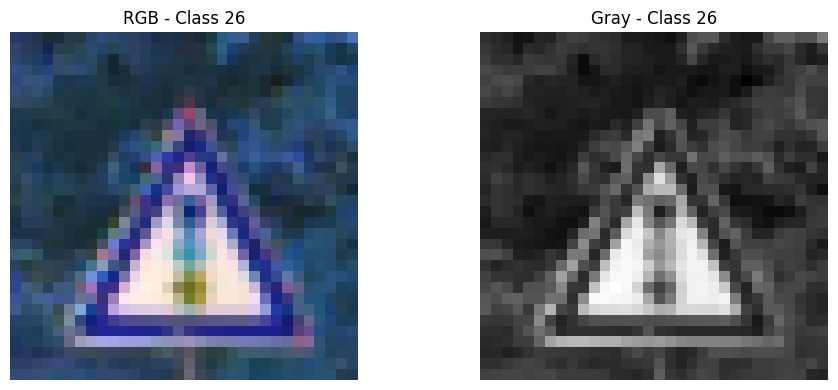

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# RGB
plt.subplot(1, 2, 1)
plt.imshow(images_rgb[0])
plt.title(f"RGB - Class {labels[0]}")
plt.axis('off')

# Grayscale
plt.subplot(1, 2, 2)
plt.imshow(images_gray[0], cmap='gray')
plt.title(f"Gray - Class {labels[0]}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = len(np.unique(labels))

# One-hot encode the labels
labels_cat = to_categorical(labels, num_classes)

# Add channel to grayscale images (from [256, 256] to [256, 256, 1])
images_gray = images_gray[..., np.newaxis]

# Train-test split
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    images_rgb, labels_cat, test_size=0.2, random_state=42, stratify=labels)

X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    images_gray, labels_cat, test_size=0.2, random_state=42, stratify=labels)

print("RGB train shape:", X_train_rgb.shape)
print("Gray train shape:", X_train_gray.shape)


RGB train shape: (9600, 32, 32, 3)
Gray train shape: (9600, 32, 32, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model_rgb = create_cnn((32, 32, 3), num_classes) # Change input shape to (32, 32, 3)
history_rgb = model_rgb.fit(X_train_rgb, y_train_rgb, epochs=50, batch_size=64,
                            validation_data=(X_test_rgb, y_test_rgb))

model_gray = create_cnn((32, 32, 1), num_classes) # Change input shape to (32, 32, 1)
history_gray = model_gray.fit(X_train_gray, y_train_gray, epochs=30, batch_size=32,
                              validation_data=(X_test_gray, y_test_gray))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.0548 - loss: 10.0386 - val_accuracy: 0.2629 - val_loss: 2.9589
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2232 - loss: 2.9115 - val_accuracy: 0.5192 - val_loss: 1.8829
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3775 - loss: 2.1625 - val_accuracy: 0.6483 - val_loss: 1.3158
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5042 - loss: 1.6601 - val_accuracy: 0.7250 - val_loss: 0.9767
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5663 - loss: 1.3668 - val_accuracy: 0.7871 - val_loss: 0.7329
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6213 - loss: 1.1696 - val_accuracy: 0.8596 - val_loss: 0.5554
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6806 - loss: 0.9878 - val_accuracy: 0.8708 - val_loss: 0.4506
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7140 - loss: 0.8602 - val_accuracy: 

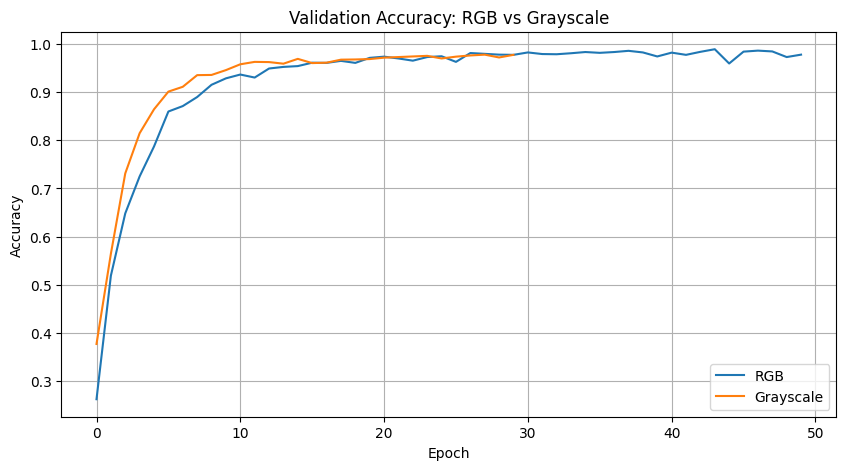

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_rgb.history['val_accuracy'], label='RGB')
plt.plot(history_gray.history['val_accuracy'], label='Grayscale')
plt.title("Validation Accuracy: RGB vs Grayscale")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_acc_rgb = history_rgb.history['val_accuracy']
val_acc_gray = history_gray.history['val_accuracy']


In [ ]:
from scipy.stats import ttest_rel

# Ensure both lists have the same length by considering the shorter length
min_len = min(len(val_acc_rgb), len(val_acc_gray))
val_acc_rgb = val_acc_rgb[:min_len]  # Trim to the shorter length
val_acc_gray = val_acc_gray[:min_len] # Trim to the shorter length

# Now perform the t-test
t_stat, p_val = ttest_rel(val_acc_rgb, val_acc_gray)
print("T-Test: t = {:.4f}, p = {:.4f}".format(t_stat, p_val))

if p_val < 0.05:
    print("✅ Significant difference in accuracy between RGB and Gray.")
else:
    print("❌ No significant difference.")

T-Test: t = -3.8815, p = 0.0006
✅ Significant difference in accuracy between RGB and Gray.


In [ ]:
from statsmodels.stats.weightstats import ztest

z_stat, p_val = ztest(val_acc_rgb, val_acc_gray)
print("Z-Test: z = {:.4f}, p = {:.4f}".format(z_stat, p_val))


Z-Test: z = -0.5913, p = 0.5543


🔍 F-statistic: 0.2066493971951334
📉 P-value: 0.6506689631114912


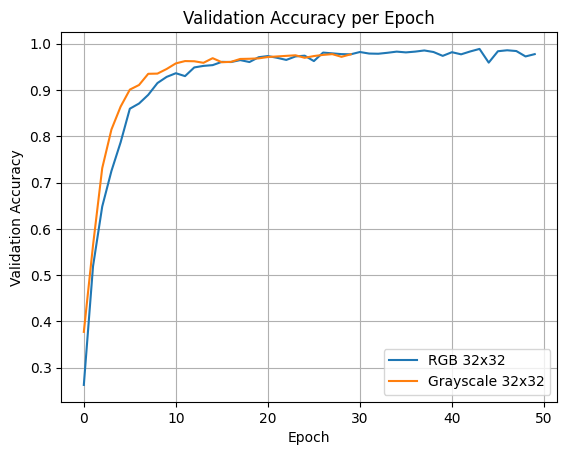

❌ No significant difference in accuracy (Fail to reject H0)


In [ ]:
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

# 📊 Extract validation accuracies
val_acc_rgb = history_rgb.history['val_accuracy']
val_acc_gray = history_gray.history['val_accuracy']

# ✅ ANOVA Test
f_stat, p_val = f_oneway(val_acc_rgb, val_acc_gray)

print("🔍 F-statistic:", f_stat)
print("📉 P-value:", p_val)

# 📈 Plotting
plt.plot(val_acc_rgb, label='RGB 32x32')
plt.plot(val_acc_gray, label='Grayscale 32x32')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 🧠 Interpretation
if p_val < 0.05:
    print("✅ Significant difference in accuracy between RGB and Grayscale (Reject H0)")
else:
    print("❌ No significant difference in accuracy (Fail to reject H0)")
